In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio

import sys
sys.path.append('../../tools/')
import fitting_functions

In [6]:
traces = ['090711e_0006', '090811c_0002', '090811d_0002', '090811d_0004','091111a_0001',
          '091111a_0003','091111c_0003','091211a_0002','091211a_0005']

### Calculate mean length of active state saccades

In [32]:
trange_active_len = np.zeros(len(traces))
for i in range(len(traces)):
    trange, data, pe_start_index, displacement_index, release_index, step_pos = fitting_functions.importActiveData('../../data/active/fixed/'+traces[i]+'.mat')
    trange_active_len[i] = trange[displacement_index]+0.5 # time 0 = 500 ms after saccade

In [33]:
np.mean(trange_active_len)

4.8424

# Compare extrapolations to "ground truth"

In [4]:
def importLongFixation(filename):
    data_file = sio.loadmat(filename)
    trange = data_file['trange'][0]
    fixation = data_file['fixation'][0]
    # fixation = fixation[::72]
    return trange, fixation

### % change in MSE as a function of number of components

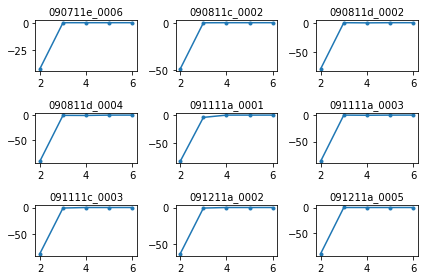

In [45]:
trange_lens = np.zeros(len(traces))
for i in range(len(traces)):
    trange, fixation = importLongFixation('../../data/long-fixations/fixed/'+traces[i]+'_long.mat')
    trange_lens[i] = len(trange)
    
    fit_file = sio.loadmat('results/'+traces[i]+'_long.mat')
    # lls = fit_file['lls']
    mse = fit_file['sses']/len(trange)
    mse_best = np.min(mse, axis=1)
    delta_mse = (mse_best[1:] - mse_best[:-1])/mse_best[:-1]
    plt.subplot(3,3,i+1)
    plt.plot(np.arange(5)+2, delta_mse*100,'.-')
    plt.title(traces[i],fontsize=10)
plt.tight_layout()

Above we plot the percent change in MSE when moving from $n-1$ to $n$ components (axis label is $n$). For all extrapolations, there was a negligible decrease in MSE after 2 components.

In [51]:
Tmin = int(np.min(trange_lens))
print(trange[Tmin])

15.26


The shortest long fixation recording we have ends at 15.26 s after saccade. We will use this time point as the end of a window over which we will evaluate the extrapolation quality, and as the point at which we will add to the cost functions for conservative extrapolations of real active state data.

In [47]:
eye_pos_averages = np.zeros(len(traces))
relative_errors = np.zeros(len(traces))
for i in range(len(traces)):
    trace = traces[i]
    trange, fixation = importLongFixation('../../data/long-fixations/fixed/'+trace+'_long.mat')
    eye_pos_averages[i] = np.mean(fixation[Tmin-16:Tmin]) # Average calculated over a window of 16 elements = 230 ms
    
    fit_file = sio.loadmat('results/'+trace+'_long.mat')
    lls = fit_file['lls']
    fits = fit_file['fits']
    best_fit_ind = np.argmin(lls[1, :])

    # Evaluate extrapolation at time corresponding to middle of window
    model_val = fitting_functions.exponentialModel(trange[Tmin-8]-trange[0], fits[1,0][best_fit_ind, :])
    relative_errors[i] = (eye_pos_averages[i]-model_val)/model_val

We use a window of 16 elements, from $t =$ 15.03 to 15.26 s after the saccade time, and calculate the average eye position. Then, we compare this to the value of the extrapolated eye position (using the first 0.5-4.8 s) at $t =$ 15.14 s, the middle of the window, by calculating the percent deviation between the extrapolation and the average eye position, with respect to the extrapolation.

In [56]:
np.mean(relative_errors), np.std(relative_errors)

(0.15957043722259426, 0.3302855581649255)

### Figure 2D, right 

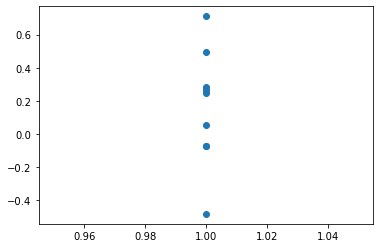

In [55]:
plt.scatter(np.ones(len(traces)), relative_errors)

In [ ]:
sio.savemat('all_relative_errors.mat', {'errs':relative_errors})
sio.savemat('relative_errors.mat', {'t':trange[Tmin-8], 'delta':np.min(relative_errors)})